In [3]:
import csv
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from datetime import datetime
import pickle
from netCDF4 import Dataset
import gdal
from mpl_toolkits.basemap import Basemap

mpl.style.use('dark_background')
plt.rcParams['svg.fonttype'] = 'none'
path_figs = 'AGU2019_figs/'
date_initial_str = '2018-05-01'
date_final_str = '2018-08-05'
months = mdates.MonthLocator()  # every month
days = mdates.DayLocator()  # every day
date_fmt = mdates.DateFormatter('%m/%d')
date_initial_plot = mdates.date2num(datetime.strptime('2018-05-01','%Y-%m-%d'))
date_initial_volumes = mdates.date2num(datetime.strptime('2018-05-01','%Y-%m-%d')) #for GLISTEN volume
date_final_plot = mdates.date2num(datetime.strptime('2018-08-05','%Y-%m-%d'))
date_eruption = mdates.date2num(datetime.strptime('2018-05-04','%Y-%m-%d'))
date_eruption_end = mdates.date2num(datetime.strptime('2018-08-04','%Y-%m-%d'))
date_explosion1 = mdates.date2num(datetime.strptime('2018-05-16','%Y-%m-%d'))
date_explosion2 = mdates.date2num(datetime.strptime('2018-05-26','%Y-%m-%d'))
date_intensity_eruption = mdates.date2num(datetime.strptime('2018-05-18','%Y-%m-%d'))
date_caldera_start = mdates.date2num(datetime.strptime('2018-05-26','%Y-%m-%d'))
date_caldera_end = mdates.date2num(datetime.strptime('2018-08-02','%Y-%m-%d'))
date_caldera_broad = mdates.date2num(datetime.strptime('2018-06-20','%Y-%m-%d'))


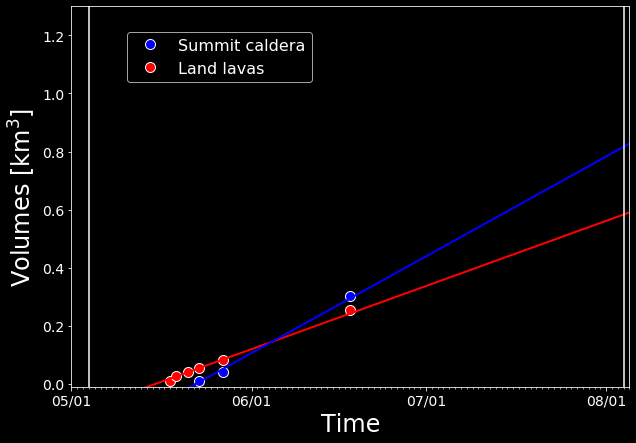

In [4]:
model_ERZ = LinearRegression()
model_summit = LinearRegression()

A = np.loadtxt('volumes.txt')
summit = A[0:4,:]
ERZ = A[4:,:]
t_summit = summit[:,0]
t_summit = date_initial_volumes - 1 + t_summit
vol_summit = -summit[:,1]/1e+9
eb_summit = summit[:,2]
t_ERZ = ERZ[:,0]
t_ERZ = date_initial_volumes - 1 + t_ERZ
vol_ERZ = ERZ[:,1]/1e+9
t_ERZ = t_ERZ.reshape(-1,1)
t_summit = t_summit.reshape(-1,1)

vol_ERZ = vol_ERZ.reshape(-1,1)
vol_summit = vol_summit.reshape(-1,1)

model_ERZ.fit(t_ERZ, vol_ERZ)
model_summit.fit(t_summit, vol_summit)

tfit = np.linspace(date_initial_volumes+3,date_initial_volumes+3+99)
vol_ERZ_fit = model_ERZ.predict(tfit[:, np.newaxis])
vol_summit_fit = model_summit.predict(tfit[:, np.newaxis])
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,7))
ax.plot(t_summit,vol_summit ,'bo',markersize = 10,linewidth = 3,markerEdgeColor = 'white' )
ax.plot(t_ERZ,vol_ERZ ,'ro',markersize = 10,linewidth = 3,markerEdgeColor = 'white' )
ax.plot(tfit,vol_ERZ_fit,'r',linewidth = 2)
ax.plot(tfit,vol_summit_fit,'b',linewidth = 2)
ax.tick_params(labelsize = 14)
ax.legend(['Summit caldera','Land lavas'],fontsize= 16,loc = (0.1,0.8))
ax.set_xlabel('Time',fontsize= 24)
ax.set_ylabel('Volumes [km$^3$]',fontsize= 24)
ax.set_ylim([-0.01,1.3])
ax.set_xlim(date_initial_plot,date_final_plot)

ax.xaxis.set_major_formatter(date_fmt)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_minor_locator(days)
ax.axvline(x=date_eruption,color = 'white')
ax.axvline(x=date_eruption_end,color = 'white')
flux = model_summit.coef_/(3600*24)*1e+9
plt.savefig(path_figs + 'volumes_fit_dark.svg')
plt.savefig(path_figs + 'volumes_fit_dark.pdf')

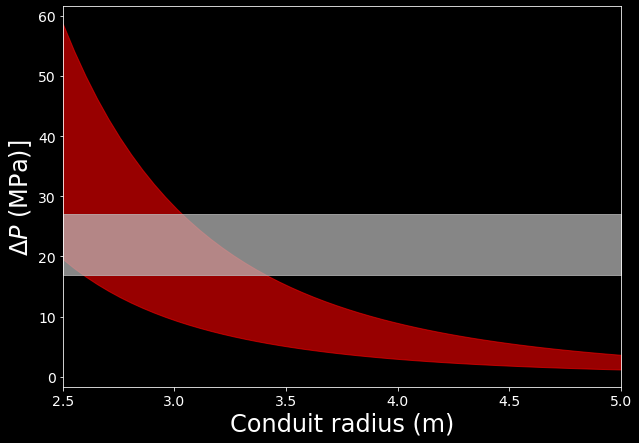

In [5]:

pi = 3.14

a = np.linspace(2.5,5)
S = pi * a**2 
ar = np.linspace(10,100,4)
mu1 = 1e+2
mu2 = 3e+2
l = 3e+4
q = 1e+2
P1 = q * 8 * mu1 * l * pi/ (S**2)/1e+6
P2 = q * 8 * mu2 * l * pi/ (S**2)/1e+6
P_litho1 = 17
P_litho2 = 27 
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,7))
ax.fill_between(a,P1,P2,color = 'red',alpha=0.6)
ax.fill_between(a,P_litho1,P_litho2,color = 'silver',alpha = 0.7)

ax.set_xlabel('Conduit radius (m)',fontsize= 24)
ax.set_ylabel('$\Delta P$ (MPa)]',fontsize= 24)
ax.set_xlim([2.5,5])
ax.tick_params(labelsize = 14)
plt.savefig(path_figs + 'flux_dark.svg')
plt.savefig(path_figs + 'flux_dark.pdf')



In [18]:
t_summit[0][0]

736837.0

NameError: name 'PCA_vectors' is not defined

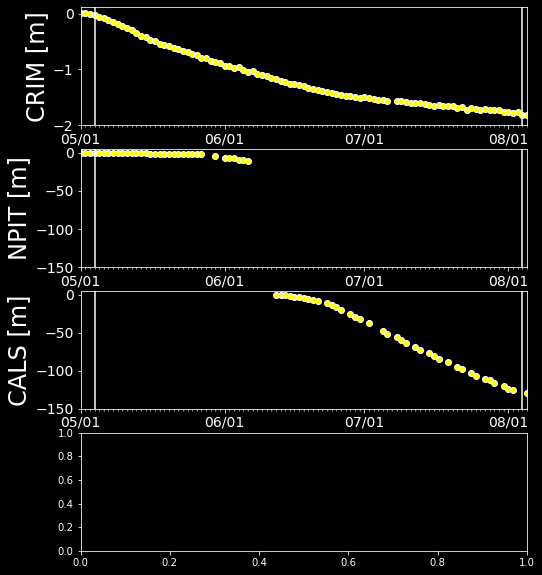

In [6]:
from scipy import signal
def get_data_segment(date_start,date_end,dates):
    #extract data between to dates expresses in human format
    number_start = mdates.date2num(datetime.strptime(date_start,'%Y-%m-%d'))
    number_end = mdates.date2num(datetime.strptime(date_end,'%Y-%m-%d'))
    ind = (dates>number_start) & (dates<number_end)
    return ind,number_start,number_end

def read_csv(filename):
  
    with open(filename) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        A = []
        for row in readCSV:
            A.append(row)
    return A

def format_gps(A):
    A = A[5:]
    t = []
    d = []
    uz = []
    for i in A:
        t.append(float(i[0]))
        d.append(i[1])
        uz.append(float(i[2])) 
    t = np.array(t)
    uz = np.array(uz)
    return t,d,uz
#Plotting GPS
path_GPS = 'GPS/'
gps_list = ['CRIM.csv','NPIT.csv','CALS.csv']
stations = pickle.load(open('tilt/tilt_dictionary_01may.pickle','rb'))
b, a = signal.butter(2, 0.03)
name = 'UWD' # Name of the station to plot
for gps in gps_list:
    data = read_csv(path_GPS + gps)
    time,date,disp = format_gps(data)
counter = 0
fig1, ax = plt.subplots(nrows = len(gps_list) + 1, ncols = 1, figsize = (8,10))
 
for gps in gps_list:
    data = read_csv(path_GPS + gps)
    time,date,disp = format_gps(data)
    date_new = []
    for line in date:
        date_temp = line[:10]
        date_new.append(mdates.date2num(datetime.strptime(date_temp,'%Y-%m-%d')))
    date = np.array(date_new)
    ax[counter].plot(date,disp - disp[0],'o',color = 'yellow',markerEdgeColor = 'white')
    ax[counter].set_ylabel(data[4][2][:4] + ' [m]',fontsize = 24)
    ax[counter].xaxis.set_major_formatter(date_fmt)
    ax[counter].xaxis.set_major_locator(months)
    ax[counter].xaxis.set_minor_locator(days)
    ax[counter].axvline(x=date_eruption,color = 'white')
    ax[counter].axvline(x=date_eruption_end,color = 'white')
    ax[counter].set_xlim([date_initial_plot,date_final_plot])
    ax[counter].tick_params(labelsize = 14)
    if (gps == 'NPIT.csv') or (gps == 'CALS.csv'):
        ax[counter].set_ylim([-150,5])
    counter = counter + 1
#Plotting tilt
east = stations[name]['east']
north = stations[name]['north']
time = stations[name]['time']
'''
Extract staff that is not nan
'''
indices = (np.isnan(north) == False) & (np.isnan(east) == False)
time = time[indices] 
east = east[indices] 
north = north[indices]
index,start,end = get_data_segment(date_initial_str,date_final_str,time)
east = east[index]
north = north[index]
time = time[index]
east = (east - east[0]) 
north = (north - north[0])
time = time[::1]
north = north[::1]
east = east[::1]
u1,w1,u2,w2,PCAmean = PCA_vectors(east,north) #Extract PCA vector and PCA mean
proj_max = east * u1 + north * w1
proj_min = east * u2 + north * w2
proj_max = signal.filtfilt(b, a, proj_max)

ax[counter].plot(time,proj_max,color = 'orange')
ax[counter].xaxis.set_major_formatter(date_fmt)
ax[counter].xaxis.set_major_locator(months)
ax[counter].xaxis.set_minor_locator(days)
ax[counter].axvline(x=date_eruption,color = 'white')
ax[counter].axvline(x=date_eruption_end,color = 'white')
ax[counter].set_xlim([date_initial_plot,date_final_plot])
ax[counter].tick_params(labelsize = 14)
ax[counter].set_ylabel(name + ' $[\mu$rad]',fontsize = 24)
ax[counter].set_xlabel('Time',fontsize = 24)
fig1.align_ylabels(ax[:])
plt.savefig(path_figs + 'timeseries.pdf')


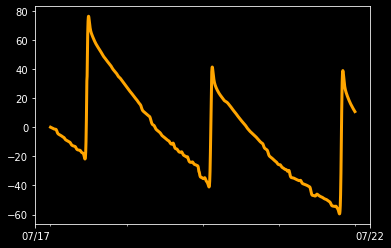

In [20]:
left_date = mdates.date2num(datetime.strptime('2018-07-18','%Y-%m-%d'))
right_date = mdates.date2num(datetime.strptime('2018-07-22','%Y-%m-%d'))
proj_zoom = proj_max[ np.logical_and(time > left_date, time < right_date)] 
time_zoom = time[ np.logical_and(time > left_date, time < right_date)]
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(time_zoom,proj_zoom  - proj_zoom[0],linewidth = 3,color ='orange')
ax.xaxis.set_major_formatter(date_fmt)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_minor_locator(days)
plt.savefig(path_figs + 'zoom.pdf')

[ 23323  23909  26544  28690  30493  32181  33427  36155  39879  41051
  43029  46073  49088  51291  53425  55498  57063  58262  59943  61209
  62756  64176  66132  67472  68678  70106  71480  72875  74846  76624
  77923  79343  80838  82618  84422  86042  87891  89948  91442  93365
  94983  96709  98677 100504 103170 105006 106645 108582 110519 112785
 115119 117590 119700 121728 126115 129722 131884 134520 137634]
Number of collapses:  52
Mean inflation event of station  UWD  is  81.4227060386966
diff_collapses [ -8.2723314    6.11340605 -12.80655194  -9.16191447  18.54723238
  -9.63110416  -5.51468696 -12.94192956   0.68238248 -16.17733333
  33.93183355 -18.80482176  -7.15431319 -14.84922702  25.03180235
   4.38615335 -11.61090181   2.25223448  -3.21375049 -13.9807761
 -12.49034847  -2.2421325  -18.21707799 -13.76930902 -18.68186376
  -9.97104641 -18.57178521 -20.86167584 -37.76386583  39.14844933
 -18.44505787  18.3879557  -20.66439633 -12.74748425   0.92152608
 -40.77615266   9.18

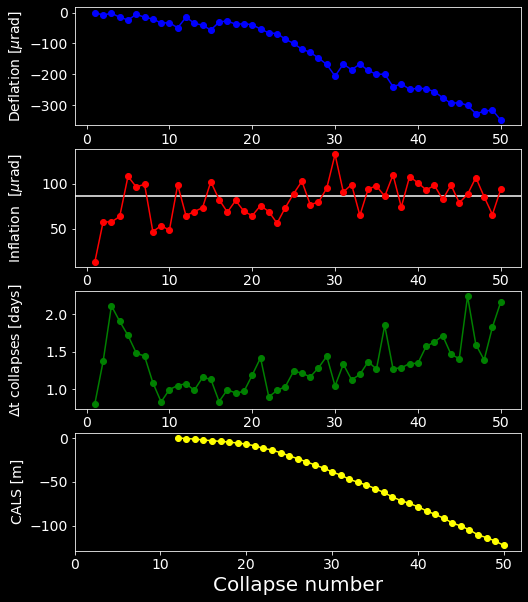

In [21]:
from scipy.interpolate import interp1d
def stick_slip(tilt_filt,dates,cald_start,station):
    if station == 'SDH':
        dist = 400
        prom = 7
    else:
        dist = 500
        prom = 10
        
    ind, _ = signal.find_peaks(tilt_filt,distance = dist,prominence= prom)
    time_peaks = dates[ind]
    peaks = tilt_filt[ind]
    min_peaks = []
    time_min_peaks = []
    for i in range(len(ind)-1):
        y = tilt_filt[ind[i]:ind[i+1]]
        x = dates[ind[i]:ind[i+1]]
        minimum = np.min(y)
        min_peaks.append(minimum)
        time_min_peaks.append(x[np.where(y==minimum)][0])
    print(ind)
    if len(ind)>0:
        y = tilt_filt[ind[-1]:]
        x = dates[ind[-1]:]
        minimum = np.min(y)
        min_peaks.append(minimum)
        time_min_peaks.append(x[np.where(y==minimum)][0])
        peaks = np.array(peaks)
        min_peaks =np.array(min_peaks[:-1])
        time_min_peaks = np.array(time_min_peaks[:-1])
        time_peaks = np.array(time_peaks)
        min_peaks = min_peaks[time_min_peaks > cald_start]
        time_min_peaks = time_min_peaks[time_min_peaks > cald_start]
        peaks = peaks[time_peaks > cald_start]
        time_peaks = time_peaks[time_peaks > cald_start]
        amp = peaks[1:] - min_peaks
        print('Number of collapses: ',len(time_peaks))

    else:
        amp = 0
    print('Mean inflation event of station ', station,' is ', np.mean(amp))

    return np.diff(time_min_peaks),time_min_peaks[:-1],amp,min_peaks

name = 'UWD'
dt_stick,time_collapses,amplitude,min_collapse = stick_slip(proj_max,time,date_caldera_start,name)
model_GPS = LinearRegression()

amplitude = amplitude[:-1]
nCollapses = np.arange(1,len(dt_stick)+1)
fig, ax = plt.subplots(nrows = 4, ncols = 1, figsize = (8,10))
event_steady = 10
ax[0].plot(nCollapses,min_collapse[:-1] - min_collapse[0],'bo')
ax[0].plot(nCollapses,min_collapse[:-1] - min_collapse[0],'b')
ax[0].tick_params(labelsize = 14)
ax[0].set_ylabel('Deflation [$\mu$rad]',fontsize =14)


ax[1].axhline(np.mean(amplitude[event_steady:]))
ax[1].plot(nCollapses,amplitude,'ro')
ax[1].plot(nCollapses,amplitude,'r')
ax[1].tick_params(labelsize = 14)
ax[1].set_ylabel('Inflation  [$\mu$rad]',fontsize =14)

ax[2].plot(nCollapses,dt_stick,'go')
ax[2].plot(nCollapses,dt_stick,'g')
ax[2].tick_params(labelsize = 14)
ax[2].set_ylabel('$\Delta$t collapses [days]',fontsize = 14)


ax[2].set_ylabel('$\Delta$t collapses [days]',fontsize = 14)
gps_list = ['CALS.csv']
for gps in gps_list:
    data = read_csv(path_GPS + gps)
    time_gps,date,disp = format_gps(data)
    date_new = []
    for line in date:
        date_temp = line[:10]
        date_new.append(mdates.date2num(datetime.strptime(date_temp,'%Y-%m-%d')))
    date_gps = np.array(date_new)
nCollapses = nCollapses[time_collapses>= date_gps[0]]
time_collapses = time_collapses[time_collapses>= date_gps[0]]
f = interp1d(date_gps,disp)
disp_interp = f(time_collapses)
ax[3].plot(nCollapses,disp_interp -  disp_interp[0],color = 'yellow')
ax[3].plot(nCollapses,disp_interp - disp_interp[0],'o',color = 'yellow' )
ax[3].tick_params(labelsize = 14)
ax[3].set_ylabel('CALS [m]',fontsize = 14)
ax[3].set_xlabel('Collapse number',fontsize = 20)
ax[3].set_xlim([0,52])
fig.align_ylabels(ax[:])
plt.savefig(path_figs + 'tilt_variables.pdf')
print('diff_collapses',np.diff(min_collapse))


(array([ 2.,  2., 10., 14.,  6.,  9.,  2.,  2.,  1.,  2.]),
 array([-40.77615266, -32.78369246, -24.79123227, -16.79877207,
         -8.80631187,  -0.81385167,   7.17860853,  15.17106873,
         23.16352893,  31.15598913,  39.14844933]),
 <a list of 10 Patch objects>)

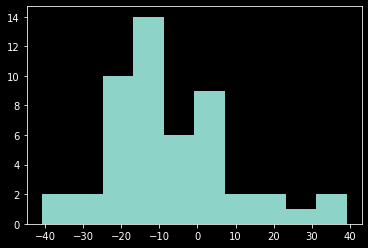

In [22]:
plt.hist(np.diff(min_collapse),10)

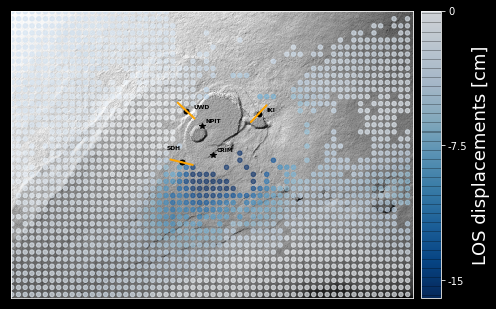

In [29]:
##### from netCDF4 import Dataset
import gdal
from sklearn.decomposition import PCA
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LightSource
import pickle 

def crop_dem(array,lat_orig,lon_orig,lat_min,lat_max,lon_min,lon_max):
    array = array[(lat_orig >= lat_min) & (lat_orig <= lat_max),:]
    array = array[:,(lon_orig >= lon_min) & (lon_orig <= lon_max)]
    return array, lat_orig[(lat_orig >= lat_min) & (lat_orig <= lat_max)],lon_orig[(lon_orig >= lon_min) & (lon_orig <= lon_max)]

def draw_vector(v0, v1,cl, head =0,ax=None,):
    #Draws a vector with no arrow using annotation. v0 and v1 are two vectors containing the coordinates of the starting point of the arrow (v0)
    #and the final point of the arrow (v1)
    ax = ax or plt.gca()
    if head:
        arrowprops=dict(arrowstyle = '->, head_width=0.3, head_length=0.5',color= cl,
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    else:
        arrowprops=dict(arrowstyle='-',color= cl,
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)
    
def PCA_vectors(x,y):
    '''
    extract principal vectors of PCA, always careful to how the vectors components are returned.
    '''
    pca = PCA(n_components=2)
    data = np.zeros((len(x),2))
    data[:,0] = x
    data[:,1] = y
    out_pca = pca.fit(data)
    umax = out_pca.components_[0,0] #First component of the vectors associated to the maximum variance
    wmax = out_pca.components_[0,1]#Second component of the vectors associated to the maximum variance
    umin = out_pca.components_[1,0] #First component of the vectors associated to the least variance
    wmin = out_pca.components_[1,1] #Second component of the vectors associated to the least variance
    return umax,wmax,umin,wmin,out_pca.mean_

def remove_value(x,y,val1,val2,par,cond):
    #Remove from vector val1 and its coordinate z,y entries that are in the val1 array according to par in the val2 array
    if cond == 'gt':
        x =  x[val2 > par]
        y = y[val2 > par]
        val1 = val1[val2 > par]
    else:
        x =  x[val2 < par]
        y = y[val2 < par]
        val1 = val1[val2 < par]
    return x,y,val1


verticalEx = 0.1    
ls = LightSource(azdeg=135, altdeg=30)

path_data_sar  = 'data/sar/'

lat_minimum = 19.31
lat_maximum = 19.48
lon_minimum = -155.40
lon_maximum = -155.15

lat_minimum_DEM = 19.31
lat_maximum_DEM = 19.48
lon_minimum_DEM = -155.40
lon_maximum_DEM = -155.15

coherence_thresh = 0.5
list_station =  ['UWD','SDH','IKI']
stations = pickle.load(open('tilt/tilt_dictionary_20june.pickle','rb')) 

step_down = 5 #Donwn sample parameter 

filename = 'S1-GUNW-D-R-087-tops-20180622_20180529-161541-20480N_18471N-PP-652b-v2_0_1.nc'
rootgrp = Dataset(path_data_sar + filename,'r')
data= rootgrp['science/grids/data/']
geometry = rootgrp['science/grids/imagingGeometry/']
wavelength = np.float64(rootgrp['science/radarMetaData'].variables['wavelength'][:])
lonMeta = geometry.variables['longitudeMeta'][:]
latMeta = geometry.variables['latitudeMeta'][:]
heightsMeta = geometry.variables['heightsMeta'][:]
heightsMeta = heightsMeta[:]
incidence = geometry.variables['incidenceAngle'][:]
look = geometry.variables['lookAngle'][:]
azimuth = geometry.variables['azimuthAngle'][:]
lon_sar = data.variables['longitude'][:]
lat_sar = data.variables['latitude'][:]
phase = data.variables['unwrappedPhase'][:]
coh = data.variables['coherence'][:]

#Cropping
phase_cropped = phase[(lat_sar > lat_minimum) & (lat_sar < lat_maximum),:]
phase_cropped = phase_cropped[:, (lon_sar > lon_minimum) & (lon_sar < lon_maximum)]
coh_cropped = coh[(lat_sar > lat_minimum) & (lat_sar < lat_maximum),:]
coh_cropped = coh_cropped[:, (lon_sar > lon_minimum) & (lon_sar < lon_maximum)]
lat_sar_cropped = lat_sar[(lat_sar > lat_minimum) & (lat_sar < lat_maximum)]
lon_sar_cropped = lon_sar[(lon_sar > lon_minimum) & (lon_sar < lon_maximum)]
phase = phase_cropped[:]
coh = coh_cropped[:]
lat = lat_sar_cropped[:]
lon = lon_sar_cropped[:]

#Downsampling
phase_downsamp = phase[::step_down,::step_down]
coh_downsamp = coh[::step_down,::step_down]
lat_downsamp = lat[::step_down]
lon_downsamp = lon[::step_down]

#Vectorizing
LON,LAT = np.meshgrid(lon,lat)
lon = LON.reshape(1,LON.size)
lat = LAT.reshape(1,LAT.size)
phase = phase.reshape(1,phase.size)
coh = coh.reshape(1,coh.size)
LON,LAT = np.meshgrid(lon_downsamp,lat_downsamp)
lon_downsamp = LON.reshape(1,LON.size)
lat_downsamp = LAT.reshape(1,LAT.size)
phase_downsamp = phase_downsamp.reshape(1,phase_downsamp.size)
coh_downsamp = coh_downsamp.reshape(1,coh_downsamp.size)
#Removing Inchoerent stuff
lon,lat, phase = remove_value(lon,lat,phase,coh,0.5,'gt')
lon_downsamp,lat_downsamp, phase_downsamp = remove_value(lon_downsamp,lat_downsamp,phase_downsamp,coh_downsamp,coherence_thresh,'gt')
los_downsamp = phase_downsamp /(4 * 3.14) * wavelength




rootgrp.close()


'''
DEM Cropping box
'''

'''
GDAL open and coordinates array creation
'''
ds = gdal.Open("tilt/dem_srtm.tif")
data = ds.ReadAsArray()
gt=ds.GetGeoTransform()
cols = ds.RasterXSize
rows = ds.RasterYSize
minx = gt[0]
miny = gt[3] + cols*gt[4] + rows*gt[5] 
maxx = gt[0] + cols*gt[1] + rows*gt[2]
maxy = gt[3]
lons = np.linspace(minx,maxx,cols)
lats = np.linspace(miny,maxy,rows)
lats = lats[::-1]
#elats = lats[::-1]
dem,lat_DEM,lon_DEM = crop_dem(data,lats,lons,lat_minimum_DEM,lat_maximum_DEM,lon_minimum_DEM,lon_maximum_DEM)    #Cropping the DEM
rgb = ls.shade(dem, cmap=plt.cm.gist_gray, vert_exag=verticalEx, blend_mode='overlay')
'''
Defining parameters for DEM plot
NOTE: as the DEM is plotted with imshow (which is in pixel coordinates), the llclon... parameters 
must correspond to the corner of the matrixm otherwise georeferencing and subsequent coordinate plot DO NOT WORK!!! 
'''
llclon = np.min(lon_DEM)
llclat = np.min(lat_DEM)
urclon = np.max(lon_DEM)
urclat = np.max(lat_DEM)
#fig2 = plt.figure()
#ax2 = fig2.add_subplot(111)
#im_dummy = ax2.scatter(lon_downsamp_map,lat_downsamp_map,s = 20,c = los_downsamp*100,alpha = 1.0 ,cmap = 'Blues_r',vmin = -16, vmax =0)

fig1 = plt.figure(1,figsize=(7,5))
map = Basemap(projection='tmerc', 
              lat_0=(llclat+urclat) * 0.5, lon_0=(llclon+urclon) * 0.5,
              llcrnrlon=llclon, 
              llcrnrlat=llclat, 
              urcrnrlon=urclon, 
              urcrnrlat=urclat)
lon_downsamp_map,lat_downsamp_map = map(lon_downsamp,lat_downsamp)
im1 = map.imshow(rgb,origin = 'upper',rasterized =True)
im2 = map.scatter(lon_downsamp_map,lat_downsamp_map,s = 20,c = los_downsamp*100,alpha = 0.6 ,cmap = 'Blues_r',***-)
cbar = map.colorbar(im2,shrink = 0.2,alpha = 1,ticks=[ 0,-7.5,-15])
cbar.ax.set_yticklabels(['0', '-7.5','-15']) 
cbar.set_label('LOS displacements [cm]',fontsize = 18)
cbar.solids.set_rasterized(True)


counter = 0
 
    if not (name == 'UWE'):             #UWD and UWE are on the same site, plotting only UWE
        map.plot(x,y,'ko',markersize = 5)
    if (name == 'SDH'):
        plt.text(x-1000,y+800,name,color = 'black',fontsize = 6,fontweight = 'bold')
    else:
        plt.text(x+500,y+150,name,color = 'black',fontsize = 6,fontweight = 'bold')
    
    counter = counter + 1
lon_crim  = -155.274
lat_crim  = 19.395
lat_npit = 19.412
lon_npit = -155.281
x_crim,y_crim = map(lon_crim,lat_crim)
x_npit,y_npit = map(lon_npit,lat_npit)

plt.text(x_crim + 200,y_crim+200,'CRIM',color = 'black',fontweight = 'bold',fontsize = 6)
map.plot(x_crim,y_crim,'k*')
plt.text(x_npit + 200,y_npit+200,'NPIT',color = 'black',fontweight = 'bold',fontsize = 6)
map.plot(x_npit,y_npit,'k*')
plt.tight_layout()
plt.savefig(path_figs + 'interferogram_tilt.pdf',dpi = 800)

# INversion results Mogi

In [23]:
import corner 
import numpy as np
import pymc3 as pm
import pandas as pd
pathgg_results = 'inversion/sar/results/'
filename = 'Mogi_Metropolis_100000_coh_0.5.pickle'
results =pickle.load(open(pathgg_results + filename,'rb'))
panda_trace = pm.backends.tracetab.trace_to_dataframe(results['trace'])
lon_inversion= results['lon']
lat_inversion = results['lat']
LOS_inversion =results['ULOS_MAP']

# Plotting inversion

In [24]:
#Plotting the original
sys.path.insert(1,'sar/')
from coord_conversion import *
x = np.ones((1,results['x'].size))
y = np.ones((1,results['y'].size))
x[0,:] = results['x']
y[0,:] = results['y']
xy = np.concatenate((x/1000,y/1000),axis = 0)
LonLat = local2llh(xy,results['ref_coord'])
lon_inversion = LonLat[0,:]
lat_inversion = LonLat[1,:]
fig1 = plt.figure(1,figsize=(20,5))
map = Basemap(projection='tmerc', 
              lat_0=(llclat+urclat) * 0.5, lon_0=(llclon+urclon) * 0.5,
              llcrnrlon=llclon, 
              llcrnrlat=llclat, 
              urcrnrlon=urclon, 
              urcrnrlat=urclat)
lon_inversion_map,lat_inversion_map = map(lon_inversion,lat_inversion)
im1 = map.imshow(rgb,origin = 'upper',rasterized =True)
im2 = map.scatter(lon_downsamp_map,lat_downsamp_map,s = 20,c = los_downsamp*100,alpha = 0.6 ,cmap = 'Blues_r',vmin = -16, vmax =0)
cbar = map.colorbar(im_dummy,shrink = 0.2,alpha = 1,ticks=[ 0,-7.5,-15])
cbar.ax.set_yticklabels(['0', '-7.5','-15']) 
cbar.set_label('LOS displacements [cm]',fontsize = 18)
cbar.solids.set_rasterized(True)
plt.tight_layout()
plt.savefig(path_figs + 'inversion_original.pdf',dpi = 800)

NameError: name 'Basemap' is not defined

<Figure size 1440x360 with 0 Axes>

In [10]:
#Plotting the inversion
sys.path.insert(1,'sar/')
from coord_conversion import *
x = np.ones((1,results['x'].size))
y = np.ones((1,results['y'].size))
x[0,:] = results['x']
y[0,:] = results['y']
xy = np.concatenate((x/1000,y/1000),axis = 0)
LonLat = local2llh(xy,results['ref_coord'])
lon_inversion = LonLat[0,:]
lat_inversion = LonLat[1,:]
fig1 = plt.figure(1,figsize=(20,5))
map = Basemap(projection='tmerc', 
              lat_0=(llclat+urclat) * 0.5, lon_0=(llclon+urclon) * 0.5,
              llcrnrlon=llclon, 
              llcrnrlat=llclat, 
              urcrnrlon=urclon, 
              urcrnrlat=urclat)
lon_inversion_map,lat_inversion_map = map(lon_inversion,lat_inversion)
im1 = map.imshow(rgb,origin = 'upper',rasterized =True)
im2 = map.scatter(lon_inversion_map,lat_inversion_map,s = 20,c = LOS_inversion*100,alpha = 0.6 ,cmap = 'Blues_r',vmin = -16, vmax =0)
cbar = map.colorbar(im_dummy,shrink = 0.2,alpha = 1,ticks=[ 0,-7.5,-15])
cbar.ax.set_yticklabels(['0', '-7.5','-15']) 
cbar.set_label('LOS displacements [cm]',fontsize = 18)
cbar.solids.set_rasterized(True)
plt.tight_layout()
plt.savefig(path_figs + 'inversion_model.pdf',dpi = 800)

NameError: name 'results' is not defined

In [11]:
x = np.ones((1,results['x'].size))
y = np.ones((1,results['y'].size))
x[0,:] = results['x']
y[0,:] = results['y']
xy = np.concatenate((x/1000,y/1000),axis = 0)
LonLat = local2llh(xy,results['ref_coord'])
lon_inversion = LonLat[0,:]
lat_inversion = LonLat[1,:]
fig1 = plt.figure(1,figsize=(20,5))
map = Basemap(projection='tmerc', 
              lat_0=(llclat+urclat) * 0.5, lon_0=(llclon+urclon) * 0.5,
              llcrnrlon=llclon, 
              llcrnrlat=llclat, 
              urcrnrlon=urclon, 
              urcrnrlat=urclat)
lon_inversion_map,lat_inversion_map = map(lon_inversion,lat_inversion)
im1 = map.imshow(rgb,origin = 'upper',rasterized =True)
im2 = map.scatter(lon_inversion_map,lat_inversion_map,s = 20,c =(results['ULOS_measured'] - LOS_inversion)*100,alpha = 0.6 ,cmap = 'Blues_r',vmin = -16, vmax =0)
cbar = map.colorbar(im_dummy,shrink = 0.2,alpha = 1,ticks=[ 0,-7.5,-15])
cbar.ax.set_yticklabels(['0', '-7.5','-15']) 
cbar.set_label('LOS displacements [cm]',fontsize = 18)
cbar.solids.set_rasterized(True)
plt.tight_layout()
plt.savefig(path_figs + 'inversion_residuals.pdf',dpi = 800)

NameError: name 'results' is not defined

In [12]:
corner.corner( panda_trace[['xSource','ySource','depthSource']],color = 'red',truths = [results['MAP']['xSource'],results['MAP']['ySource'],results['MAP']['depthSource']])
plt.savefig(path_figs + 'inversions_stats.pdf')


NameError: name 'corner' is not defined

# Equations
Control parameters are
\begin{equation}
\Psi = \frac{\rho g V_0}{kS}
\end{equation}

\begin{equation}
\Phi = \frac{P_l - P_s}{P_s - P_d}
\end{equation}

\begin{equation}
\tau = \frac{\pi a ^4}{8\mu V_0 l}
\end{equatiomn}

In the dimensional form

\begin{equation}
dx = \frac{\Psi}{\rho g}\frac{P_s- P_d}{1 + \Psi}
\end{equation}

where $Ps= Fs/S$. The pressure jump is given by

\begin{equation}
\Delta P_{slip} = 2 \frac{P_s- P_d}{1+\Psi}
\end{equation}

The difference in pressure between two slip event is given by

\begin{equation}
\Delta P_{deficit} = - 2 \Psi \frac{P_s- P_d}{1 + \Psi} 
\end{equation}

The time between slip events with R2 << 1 is 

\begin{equation}
\Delta t = -\tau \log\Bigg[\frac{(1 + \Psi)\Phi - 2\Psi n}{(1+\Psi)\Phi  -2\Psi n +2\Psi +2}\Bigg]
\end{equation}

with $\phi = \frac{P_l - Ps}{P_s- P_d}$
so that the total number of slip event is
\begin{equation}
n = ceil(\frac{1 + \Psi}{2\Psi}\Phi)
\end{equation}
And the piston is at  position 
\begin{equation}
x = \frac{(P_l - Ps)}{\rho g} 
\end{equation}

# Time series examples

Ending! No more underpressure available to drag the piston down 0.8938824056030243
19
Phi is  0.12345679012345678
Psi is 0.0034394904458598732


0.1

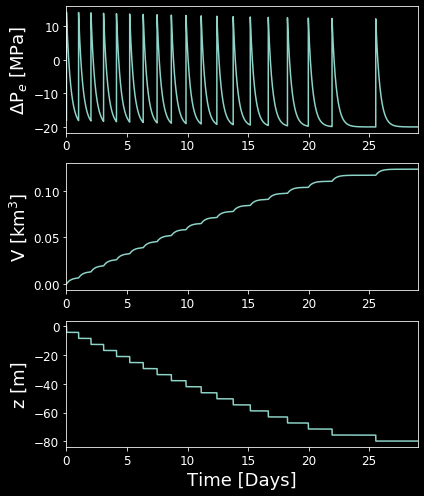

In [13]:
import sys
sys.path.insert(1,'model/')
from solvers_piston import *

x0 = 0
g = 9.8
rho = 2700
#chamber and elasticity
V0= 1e+9
k = 5.e+9
#Piston geometrical parameters
Rp = 7e+2
hp = 5e+2
S = 3.14 * Rp**2
Vp = S * hp
m = rho * Vp
#Conduit and mama properties
a = 4.
mu = 5e+2
l = 3e+4
#Friction properties
c0 = 18e+6
fric_coef = 0.01
Fs = c0 * S
R5 = 0.1
Fd = Fs * R5
#Driving pressure
Pl =2.0e+7
pstar = c0
tstar = ((m*V0) / (k* S**2))**0.5
xstar = Fs*V0/(k*S**2)
qstar = Fs *(V0/(k*m))**0.5
Vstar = xstar * S
R1 = rho * g * V0 /(k*S)
R2 = (m * k / V0)**0.5 *(3.14 * a**4 )/(8* mu * l* S) 
R3 = Pl / Fs * S
R4 = -1
x0 = x0/xstar
tc = 3.14 * a**4 *k/ (8* mu * l * V0)
DeltaP,x,velocity,N_cycle,time,t_slip,dt_slip,dx_slip,slip_duration,q_out,vol_out,p_slip,dp_slip = isostatic_piston(x0,R1,R2,R3,R4,R5)
DeltaP = DeltaP * pstar
x = x * xstar
x = -x
vol_out = vol_out* Vstar
time = time * tstar
DeltaP_nocol = (Pl + DeltaP[0]) * np.exp(-tc *time) - Pl
V_nocol = V0/k *(DeltaP[0] + Pl) * (1 - np.exp(-tc * time))
DeltaP = DeltaP / 1e+6
DeltaP_nocol = DeltaP_nocol / 1e+6
vol_out = vol_out / 1e+9
V_nocol = V_nocol / 1e+9
time = time / (3600 *24)
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (6,7))
ax[0].plot(time,DeltaP)
#ax[0].plot(time,DeltaP_nocol)
ax[0].set_ylabel('$\Delta$P$_e$ [MPa]',fontsize= 18)
ax[0].tick_params(labelsize = 12)
ax[0].set_xlim([0,time[-1]])
ax[0].tick_params(labelsize = 12)
ax[1].plot(time,vol_out)
#ax[1].plot(time,V_nocol)
ax[1].set_ylabel('V [km$^3$]',fontsize= 18)
ax[1].tick_params(labelsize = 12)
ax[1].set_xlim([0,time[-1]])

ax[2].plot(time,x)
ax[2].set_xlabel('Time [Days]',fontsize= 18)
ax[2].tick_params(labelsize = 12)
ax[2].set_ylabel('z [m]',fontsize= 18)

ax[2].set_xlim([0,time[-1]])
fig.align_ylabels(ax[:])
plt.tight_layout()
print(N_cycle)
plt.savefig(path_figs + 'synthetic_friction.pdf')
DeltaP[0],DeltaP_nocol[0]
phi = ((Pl - c0) / (c0 - Fd/S))
print('Phi is ',phi)
print('Psi is', R1)
R5

Ending! No more underpressure available to drag the piston down 0.1511140562405492
35
Phi is  10.093167701863347
Psi is 0.17197452229299365


0.816

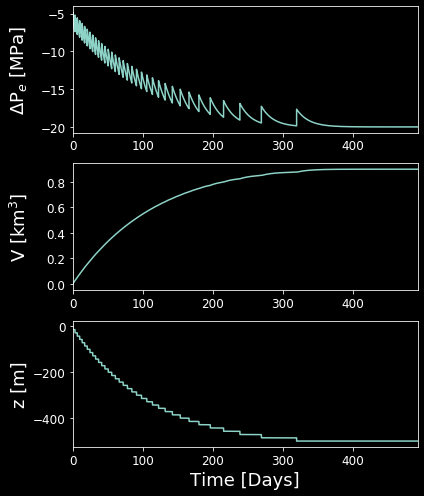

In [14]:
x0 = 0
g = 9.8
rho = 2700
#chamber and elasticity
V0= 1e+10
k = 1.e+9
#Piston geometrical parameters
Rp = 7e+2
hp = 5e+2
S = 3.14 * Rp**2
Vp = S * hp
m = rho * Vp
#Conduit and mama properties
a = 4.
mu = 5e+2
l = 3e+4
#Friction properties
c0 = 7e+6
fric_coef = 0.01
Fs = c0 * S
R5 = 0.816
Fd = Fs * R5
#Driving pressure
Pl =2.0e+7
pstar = c0
tstar = ((m*V0) / (k* S**2))**0.5
xstar = Fs*V0/(k*S**2)
qstar = Fs *(V0/(k*m))**0.5
Vstar = xstar * S
R1 = rho * g * V0 /(k*S)
R2 = (m * k / V0)**0.5 *(3.14 * a**4 )/(8* mu * l* S) 
R3 = Pl / Fs * S
R4 = -1
x0 = x0/xstar
tc = 3.14 * a**4 *k/ (8* mu * l * V0)
DeltaP,x,velocity,N_cycle,time,t_slip,dt_slip,dx_slip,slip_duration,q_out,vol_out,p_slip,dp_slip = isostatic_piston(x0,R1,R2,R3,R4,R5)
DeltaP = DeltaP * pstar
x = x * xstar
x = -x
vol_out = vol_out* Vstar
time = time * tstar
DeltaP_nocol = (Pl + DeltaP[0]) * np.exp(-tc *time) - Pl
V_nocol = V0/k *(DeltaP[0] + Pl) * (1 - np.exp(-tc * time))
DeltaP = DeltaP / 1e+6
DeltaP_nocol = DeltaP_nocol / 1e+6
vol_out = vol_out / 1e+9
V_nocol = V_nocol / 1e+9
time = time / (3600 *24)
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (6,7))
ax[0].plot(time,DeltaP)
#ax[0].plot(time,DeltaP_nocol)
ax[0].set_ylabel('$\Delta$P$_e$ [MPa]',fontsize= 18)
ax[0].tick_params(labelsize = 12)
ax[0].set_xlim([0,time[-1]])
ax[0].tick_params(labelsize = 12)
ax[1].plot(time,vol_out)
#ax[1].plot(time,V_nocol)
ax[1].set_ylabel('V [km$^3$]',fontsize= 18)
ax[1].tick_params(labelsize = 12)
ax[1].set_xlim([0,time[-1]])

ax[2].plot(time,x)
ax[2].set_xlabel('Time [Days]',fontsize= 18)
ax[2].tick_params(labelsize = 12)
ax[2].set_ylabel('z [m]',fontsize= 18)

ax[2].set_xlim([0,time[-1]])
fig.align_ylabels(ax[:])
plt.tight_layout()
print(N_cycle)
plt.savefig(path_figs + 'synthetic_litho.pdf')
DeltaP[0],DeltaP_nocol[0]
phi = ((Pl - c0) / (c0 - Fd/S))
print('Phi is ',phi)
print('Psi is', R1)
R5

Ending! No more underpressure available to drag the piston down 0.8651324314237113
25
Phi is  2.0634920634920637
Psi is 0.04388933121019109


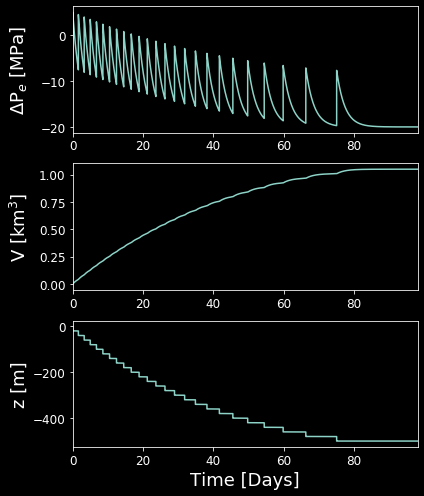

In [15]:
x0 = 0
g = 9.8
rho = 2700
#chamber and elasticity
V0= 5e+9
k = 1.5e+9
#Piston geometrical parameters
Rp = 8e+2
hp = 5e+2
S = 3.14 * Rp**2
Vp = S * hp
m = rho * Vp
#Conduit and mama properties
a = 4.
mu = 2e+2
l = 3e+4
#Friction properties
c0 = 7e+6
Fs = c0 * S
R5 = 0.1
Fd = Fs * R5
#Driving pressure
Pl =2e+7
pstar = c0
tstar = ((m*V0) / (k* S**2))**0.5
xstar = Fs*V0/(k*S**2)
qstar = Fs *(V0/(k*m))**0.5
Vstar = xstar * S
R1 = rho * g * V0 /(k*S)
R2 = (m * k / V0)**0.5 *(3.14 * a**4 )/(8* mu * l* S) 
R3 = Pl / Fs * S
R4 = -1
x0 = x0/xstar
tc = 3.14 * a**4 *k/ (8* mu * l * V0)
DeltaP,x,velocity,N_cycle,time,t_slip,dt_slip,dx_slip,slip_duration,q_out,vol_out,p_slip,dp_slip = isostatic_piston(x0,R1,R2,R3,R4,R5)
DeltaP = DeltaP * pstar
x = x * xstar
x = -x
vol_out = vol_out* Vstar
time = time * tstar
DeltaP_nocol = (Pl + DeltaP[0]) * np.exp(-tc *time) - Pl
V_nocol = V0/k *(DeltaP[0] + Pl) * (1 - np.exp(-tc * time))
DeltaP = DeltaP / 1e+6
DeltaP_nocol = DeltaP_nocol / 1e+6
vol_out = vol_out / 1e+9
V_nocol = V_nocol / 1e+9
time = time / (3600 *24)
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (6,7))
ax[0].plot(time,DeltaP)
#ax[0].plot(time,DeltaP_nocol)
ax[0].set_ylabel('$\Delta$P$_e$ [MPa]',fontsize= 18)
ax[0].tick_params(labelsize = 12)
ax[0].set_xlim([0,time[-1]])
ax[1].plot(time,vol_out)
#ax[1].plot(time,V_nocol)
ax[1].set_ylabel('V [km$^3$]',fontsize= 18)
ax[0].tick_params(labelsize = 12)
ax[1].tick_params(labelsize = 12)
ax[1].set_xlim([0,time[-1]])
ax[2].plot(time,x)
ax[2].set_ylabel('z [m]',fontsize= 18)
ax[2].set_xlabel('Time [Days]',fontsize= 18)
ax[2].tick_params(labelsize = 12)
ax[2].set_xlim([0,time[-1]])
fig.align_ylabels(ax[:])
plt.tight_layout()
print(N_cycle)
plt.savefig(path_figs + 'synthetic_interm.pdf')
DeltaP[0],DeltaP_nocol[0]
phi = ((Pl - c0) / (c0 - Fd/S))
print('Phi is ',phi)
print('Psi is', R1)

Ending! No more underpressure available to drag the piston down 0.4772303868159522


/anaconda3/envs/pyMC/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/anaconda3/envs/pyMC/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


62


/anaconda3/envs/pyMC/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/anaconda3/envs/pyMC/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


Phi is  3.7142857142857144
Psi is 0.031268094962362485
[8.02174199 8.02173275 8.02172397 8.02171518 8.02170642 8.02169767
 8.02168892 8.02168029 8.02167161 8.02166284 8.02165406 8.02164528
 8.0216365  8.02162772 8.02161874 8.02160997 8.02160119 8.02159241
 8.02158363 8.02157485 8.02156607 8.02155729 8.02154851 8.02153877
 8.02152998 8.02152119 8.0215124  8.0215036  8.02149481 8.02148602
 8.02147723 8.02146844 8.02145964 8.02145085 8.02144206 8.02143327
 8.02142448 8.02141569 8.02140691 8.02139813 8.02138935 8.02138057
 8.02137178 8.021363   8.02135422 8.02134543 8.02133665 8.02132787
 8.02131912 8.02131033 8.02130154 8.02129276 8.02128401 8.02127527
 8.02126655 8.02125783 8.02124911 8.02124039 8.02123166 8.02122293
 8.02121419 8.02120546]


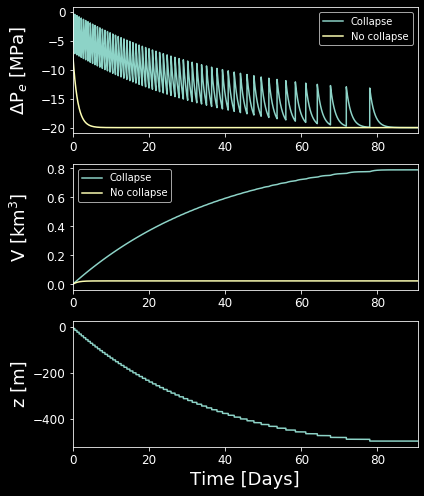

In [16]:
x0 = 0
g = 9.8
rho = 2700
#chamber and elasticity
V0= 4.e+9
k = 2.2e+9
#Piston geometrical parameters
Rp = 7e+2
hp = 5e+2
S = 3.14 * Rp**2
Vp = S * hp
m = rho * Vp
#Conduit and mama properties
a = 4.
mu = 2e+2
l = 3e+4
#Friction properties
c0 = 7e+6
Fs = c0 * S
R5 = 0.5
Fd = Fs * R5
#Driving pressure
Pl =2e+7
pstar = c0
tstar = ((m*V0) / (k* S**2))**0.5
xstar = Fs*V0/(k*S**2)
qstar = Fs *(V0/(k*m))**0.5
Vstar = xstar * S
R1 = rho * g * V0 /(k*S)
R2 = (m * k / V0)**0.5 *(3.14 * a**4 )/(8* mu * l* S) 
R3 = Pl / Fs * S
R4 = -1
x0 = x0/xstar
tc = 3.14 * a**4 *k/ (8* mu * l * V0)
DeltaP,x,velocity,N_cycle,time,t_slip,dt_slip,dx_slip,slip_duration,q_out,vol_out,p_slip,dp_slip = isostatic_piston(x0,R1,R2,R3,R4,R5)
DeltaP = DeltaP * pstar
dx_slip = dx_slip * xstar
x = x * xstar
x = -x
vol_out = vol_out* Vstar
time = time * tstar
DeltaP_nocol = (Pl + DeltaP[0]) * np.exp(-tc *time) - Pl
V_nocol = V0/k *(DeltaP[0] + Pl) * (1 - np.exp(-tc * time))
DeltaP = DeltaP / 1e+6
DeltaP_nocol = DeltaP_nocol / 1e+6
vol_out = vol_out / 1e+9
V_nocol = V_nocol / 1e+9
time = time / (3600 *24)
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (6,7))
ax[0].plot(time,DeltaP)
ax[0].plot(time,DeltaP_nocol)
ax[0].legend(['Collapse','No collapse'])
ax[0].set_ylabel('$\Delta$P$_e$ [MPa]',fontsize= 18)
ax[0].tick_params(labelsize = 12)
ax[0].set_xlim([0,time[-1]])
ax[1].plot(time,vol_out)
ax[1].plot(time,V_nocol)
ax[1].set_ylabel('V [km$^3$]',fontsize= 18)
ax[0].tick_params(labelsize = 12)
ax[1].tick_params(labelsize = 12)
ax[1].set_xlim([0,time[-1]])
ax[1].legend(['Collapse','No collapse'])

ax[2].plot(time,x)
ax[2].set_ylabel('z [m]',fontsize= 18)
ax[2].set_xlabel('Time [Days]',fontsize= 18)
ax[2].tick_params(labelsize = 12)
ax[2].set_xlim([0,time[-1]])
fig.align_ylabels(ax[:])
plt.tight_layout()
print(N_cycle)
plt.savefig(path_figs + 'synthetic_interm_nocollapse.pdf')
DeltaP[0],DeltaP_nocol[0]
phi = ((Pl - c0) / (c0 - Fd/S))
print('Phi is ',phi)
print('Psi is', R1)
print(dx_slip)

In [17]:
dx_slip

array([8.02174199, 8.02173275, 8.02172397, 8.02171518, 8.02170642,
       8.02169767, 8.02168892, 8.02168029, 8.02167161, 8.02166284,
       8.02165406, 8.02164528, 8.0216365 , 8.02162772, 8.02161874,
       8.02160997, 8.02160119, 8.02159241, 8.02158363, 8.02157485,
       8.02156607, 8.02155729, 8.02154851, 8.02153877, 8.02152998,
       8.02152119, 8.0215124 , 8.0215036 , 8.02149481, 8.02148602,
       8.02147723, 8.02146844, 8.02145964, 8.02145085, 8.02144206,
       8.02143327, 8.02142448, 8.02141569, 8.02140691, 8.02139813,
       8.02138935, 8.02138057, 8.02137178, 8.021363  , 8.02135422,
       8.02134543, 8.02133665, 8.02132787, 8.02131912, 8.02131033,
       8.02130154, 8.02129276, 8.02128401, 8.02127527, 8.02126655,
       8.02125783, 8.02124911, 8.02124039, 8.02123166, 8.02122293,
       8.02121419, 8.02120546])

Ending! No more underpressure available to drag the piston down 0.08513791348597344
129
Phi is  30.0
Psi is 0.13228809407153358


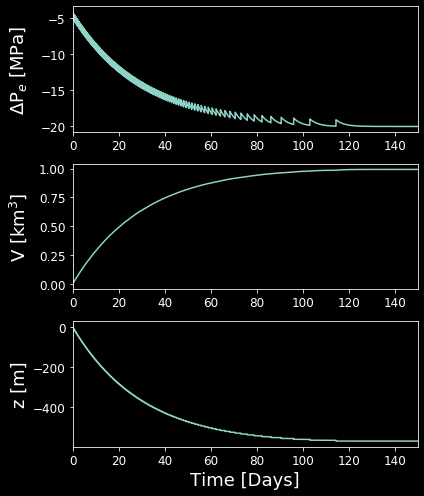

In [18]:
x0 = 0
g = 9.8
rho = 2700
#chamber and elasticity
V0= 1e+10
k = 1.3e+9
#Piston geometrical parameters
Rp = 7e+2
hp = 5e+2
S = 3.14 * Rp**2
Vp = S * hp
m = rho * Vp
#Conduit and mama properties
a = 4.
mu = 1e+2
l = 4e+4
#Friction properties
c0 = 5e+6
Fs = c0 * S
R5 = 0.9
Fd = Fs * R5
#Driving pressure
Pl =2e+7
pstar = c0
tstar = ((m*V0) / (k* S**2))**0.5
xstar = Fs*V0/(k*S**2)
qstar = Fs *(V0/(k*m))**0.5
Vstar = xstar * S
R1 = rho * g * V0 /(k*S)
R2 = (m * k / V0)**0.5 *(3.14 * a**4 )/(8* mu * l* S) 
R3 = Pl / Fs * S
R4 = -1
x0 = x0/xstar
tc = 3.14 * a**4 *k/ (8* mu * l * V0)
DeltaP,x,velocity,N_cycle,time,t_slip,dt_slip,dx_slip,slip_duration,q_out,vol_out,p_slip,dp_slip = isostatic_piston(x0,R1,R2,R3,R4,R5)
DeltaP = DeltaP * pstar
x = x * xstar
x = -x
vol_out = vol_out* Vstar
time = time * tstar
DeltaP_nocol = (Pl + DeltaP[0]) * np.exp(-tc *time) - Pl
V_nocol = V0/k *(DeltaP[0] + Pl) * (1 - np.exp(-tc * time))
DeltaP = DeltaP / 1e+6
DeltaP_nocol = DeltaP_nocol / 1e+6
vol_out = vol_out / 1e+9
V_nocol = V_nocol / 1e+9
time = time / (3600 *24)
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (6,7))
ax[0].plot(time,DeltaP)
#ax[0].plot(time,DeltaP_nocol)
ax[0].set_ylabel('$\Delta$P$_e$ [MPa]',fontsize= 18)
ax[0].tick_params(labelsize = 12)
ax[0].set_xlim([0,time[-1]])
ax[1].plot(time,vol_out)
#ax[1].plot(time,V_nocol)
ax[1].set_ylabel('V [km$^3$]',fontsize= 18)
ax[0].tick_params(labelsize = 12)
ax[1].tick_params(labelsize = 12)
ax[1].set_xlim([0,time[-1]])
ax[2].plot(time,x)
ax[2].set_ylabel('z [m]',fontsize= 18)
ax[2].set_xlabel('Time [Days]',fontsize= 18)
ax[2].tick_params(labelsize = 12)
ax[2].set_xlim([0,time[-1]])
fig.align_ylabels(ax[:])
plt.tight_layout()
print(N_cycle)
plt.savefig(path_figs + 'synthetic_interm.pdf')
DeltaP[0],DeltaP_nocol[0]
phi = ((Pl - c0) / (c0 - Fd/S))
print('Phi is ',phi)
print('Psi is', R1)

In [19]:
def get_data_segment(date_start,date_end,dates):
    #extract data between to dates expresses in human format
    number_start = mdates.date2num(datetime.strptime(date_start,'%Y-%m-%d'))
    number_end = mdates.date2num(datetime.strptime(date_end,'%Y-%m-%d'))
    ind = (dates>number_start) & (dates<number_end)
    return ind,number_start,number_end

def plot_stick_slip(tilt_filt,dates,cald_start,station,fmt,majloc,minloc):
    if station == 'SDH':
        dist = 400
        prom = 7
    else:
        dist = 500
        prom = 10
        
    ind, _ = signal.find_peaks(tilt_filt,distance = dist,prominence= prom)
    time_peaks = dates[ind]
    peaks = tilt_filt[ind]
    min_peaks = []
    time_min_peaks = []
    for i in range(len(ind)-1):
        y = tilt_filt[ind[i]:ind[i+1]]
        x = dates[ind[i]:ind[i+1]]
        minimum = np.min(y)
        min_peaks.append(minimum)
        time_min_peaks.append(x[np.where(y==minimum)][0])
        print('Number of collapses: ',len(time_peaks))

    print(ind)
    if len(ind)>0:
        y = tilt_filt[ind[-1]:]
        x = dates[ind[-1]:]
        minimum = np.min(y)
        min_peaks.append(minimum)
        time_min_peaks.append(x[np.where(y==minimum)][0])
        peaks = np.array(peaks)
        min_peaks =np.array(min_peaks[:-1])
        time_min_peaks = np.array(time_min_peaks[:-1])
        time_peaks = np.array(time_peaks)
        min_peaks = min_peaks[time_min_peaks > cald_start]
        time_min_peaks = time_min_peaks[time_min_peaks > cald_start]
        peaks = peaks[time_peaks > cald_start]
        time_peaks = time_peaks[time_peaks > cald_start]
        amp = peaks - min_peaks
        print('Number of collapses: ',len(time_peaks))
        fig = plt.figure()
        ax.plot(dates,tilt_filt)
        ax.plot(time_peaks,peaks,'ro-')
        ax.plot(time_min_peaks,min_peaks,'bo-')
        ax.xaxis.set_major_formatter(fmt)
        ax.xaxis.set_major_locator(majloc)
        ax.xaxis.set_minor_locator(minloc)
        ax.set_xlim([beginning,end])
        plt.show()
    return np.diff(time_min_peaks),time_min_peaks[:-1],peaks,min_peaks
name ='UWD'

east = stations[name]['east']
north = stations[name]['north']
time = stations[name]['time']
'''
Extract staff that is not nan
'''
indices = (np.isnan(north) == False) & (np.isnan(east) == False)
time = time[indices] 
east = east[indices] 
north = north[indices]

east = (east - east[0]) 
north = (north - north[0])
time = time[::1]
north = north[::1]
east = east[::1]

u1,w1,u2,w2,PCAmean = PCA_vectors(east,north) #Extract PCA vector and PCA mean
proj_max = east * u1 + north * w1
proj_min = east * u2 + north * w2
if not(name=='POO'):
    proj_max = signal.filtfilt(b, a, proj_max)
dt_stick,time_collapses,pstick,pslip = plot_stick_slip(proj_max,time,date_caldera_start,name,date_fmt,months,days)
dt_stick

NameError: name 'stations' is not defined

<Figure size 432x288 with 0 Axes>

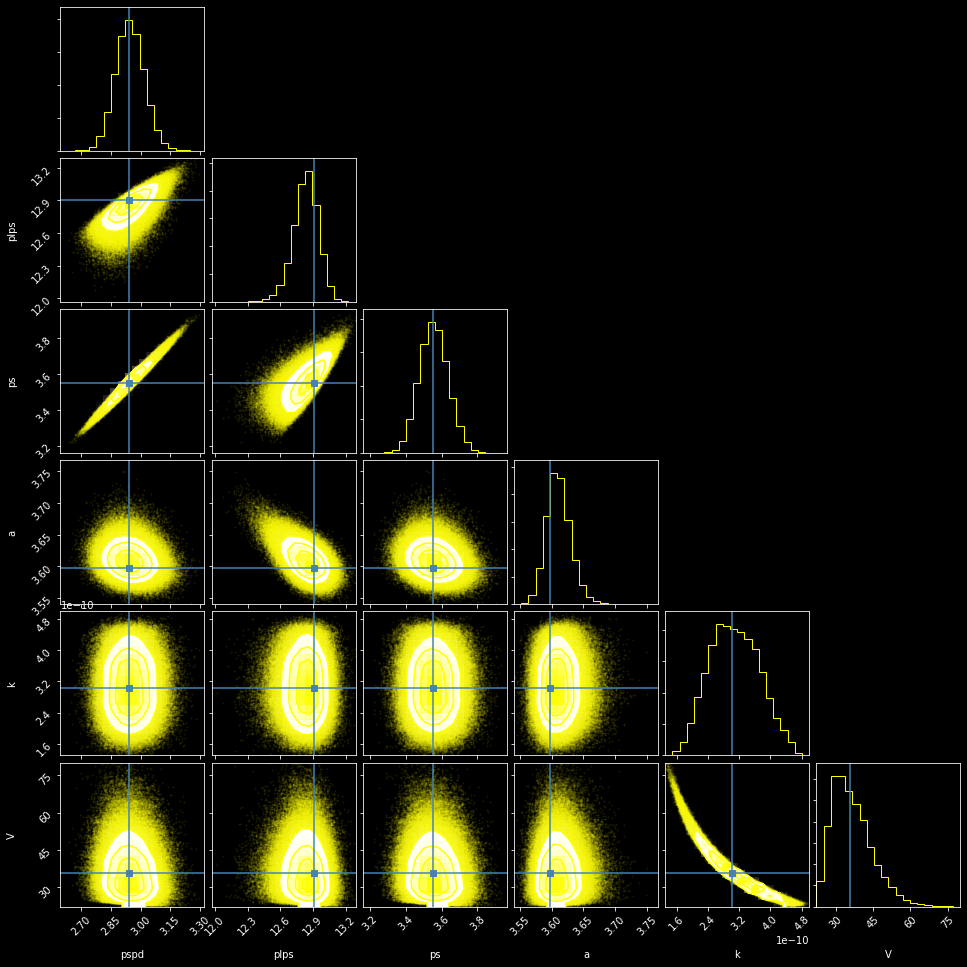

In [28]:
pathgg_results = 'inversion/dynamical_model/UWD/'
filename = 'mu_100_Rp_700.pickle'
rho = 2600
g = 9.8
lame = 1e+9
poisson = 0.25
mu = 100
l = 4e+4

results =pickle.load(open(pathgg_results + filename,'rb'))
panda_trace = pm.backends.tracetab.trace_to_dataframe(results['trace'])
panda_trace['V'] = (panda_trace['V']) /1e+9 
panda_trace['k'] = 1 / ((panda_trace['k']))
panda_trace['ps'] = panda_trace['ps'] / 1e+6 
panda_trace['pspd'] = panda_trace['ps']   - panda_trace['pspd'] / 1e+6    
panda_trace['plps'] = panda_trace['plps'] / 1e+6                        #Change this if chainging k or volume
panda_trace['plps'] = panda_trace['plps'] + panda_trace['ps']                        #Change this if chainging k or volume

plt.figure(1)
corner.corner( panda_trace[['pspd','plps','ps','a','k','V']],color = 'yellow',
              truths = [+results['MAP']['ps']/1e+6 - results['MAP']['pspd']/1e+6,results['MAP']['plps']/1e+6 +results['MAP']['ps']/1e+6 ,results['MAP']['ps']/1e+6,
                        results['MAP']['a'],1 / (results['MAP']['k']),(results['MAP']['V'])/1e+9])
plt.savefig(path_figs + 'inversions_dynamical_stats.pdf')


/anaconda3/envs/pyMC/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -153.58, ||grad|| = 0.19618: 100%|██████████| 108/108 [00:00<00:00, 2059.42it/s] 


0.1854987160129047


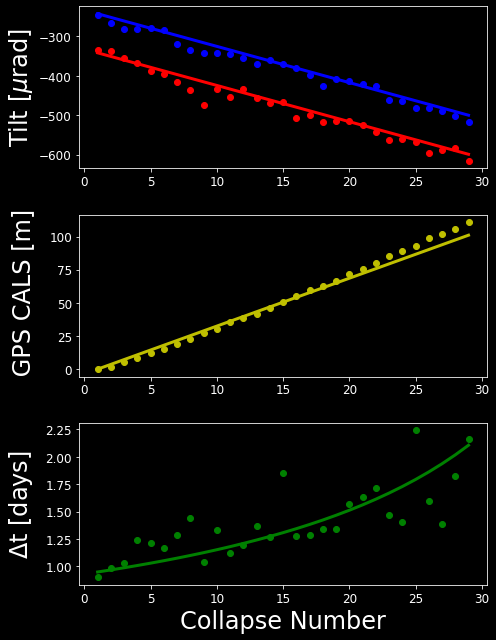

In [38]:
### import numpy as np
import theano
import theano.tensor as tt
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"
import pymc3 as pm
import pickle as pickle
import matplotlib.pyplot as plt
import sys
sys.path.insert(1,'sar/')
from coord_conversion import *


g = 9.8
rho = 2700
#chamber and elasticity
#Elastic properties crust
poisson = 0.25
lame = 1e+9
#Position of the chamber
#Piston geometrical parameters
Rp = 7e+2
S = 3.14 * Rp**2
#Conduit Properties
l = 4e+4
mu =  100
tiltName = 'UWD'
filename = 'DataForInversion' + tiltName + '.pickle'
data = pickle.load(open('inversion/dynamical_model/' + filename,'rb'))
tilt_stick = data['tilt_stick'] * 1e-6
tilt_slip =  data['tilt_slip'] * 1e-6
tilt_std = data['tilt_std'] * 1e-6
dt_stick = data['dt_stick'] * 3600 * 24 
x = -data['gps']
dt_std = 60
x_std =1
xSource = 84
ySource =  82
depth_estimate = 3200
ref_point = np.array([-155.274,19.395])  # Ref point is alway CRIM
xy = llh2local(data['LonLat'],ref_point) *1000
radial_distance = ((xy[0] - xSource)**2 + (xy[1] - ySource)**2)**0.5
#radial_distance = 1000
n = np.arange(1,len(tilt_stick)+ 1 )
Nmax = len(n)
nSample = 70000
#Setup inversion
with pm.Model() as model:
    V_exp = pm.Uniform('V_exp',lower = 8,upper = 11)
    k_exp = pm.Uniform('k_exp',lower = 8, upper = 11)
    V = pm.Deterministic('V',10**V_exp)
    k = pm.Deterministic('k',10**k_exp)
    ps = pm.Uniform('ps',lower=1e+6,upper=2e+7)   
    pspd = pm.Uniform('pspd',lower=1e+5,upper=2e+7)
    a = pm.Uniform('a',lower=1,upper=10)
    depth = pm.Normal('depth',mu = depth_estimate, sigma = 500)
    R = (radial_distance**2 + depth**2)**0.5 # Change this if including deepth in the inversion
    R1 = rho * g * V /(k * S)                           #Change this if chainging k or volume

    low_bound = 2 * Nmax * R1 / (1 + R1) * pspd
    up_bound = 2 * (Nmax + 20) * R1 / (1 + R1) * pspd
    plps = pm.Uniform('plps',lower=low_bound,upper=up_bound)
    phi = plps / pspd
    tau =  8 * mu *l * V/ (3.14 * a**4 * k)               #Change this if inverting k or volume
    #Model set-up
    dt_mod = -tau * pm.math.log(((1 + R1) * phi - 2 * n * R1 ) / (((1 + R1) *phi - 2 *(R1*(n -1) -1))))
    x_mod = R1 / (rho * g) * pspd / (1 + R1) * n
    pslip_mod = -ps -rho * g * x_mod
    pstick_mod = pslip_mod + 2 * pspd/ (1 + R1)

#    tilt_mod = (-ps_mod * V_mod  -rho * g * V_mod * x) * tilt_coeff_inversion 
    tilt_coeff =  9./(4*3.14) * V * (1 - poisson)/lame* radial_distance * depth/(R**5) #Change this if inverting volume or depth
    tilt_slip_mod = pslip_mod * tilt_coeff
    tilt_stick_mod =pstick_mod * tilt_coeff
    
    #Posterio
    Tst_obs = pm.Normal('Tst_obs', mu=tilt_stick_mod, sigma = tilt_std, observed=tilt_stick)
    Tsl_obs = pm.Normal('Tsl_obs', mu=tilt_slip_mod, sigma = tilt_std, observed=tilt_slip)
    dt_obs = pm.Normal('dt_obs', mu = dt_mod, sigma = 10000, observed = dt_stick)
    x_obs = pm.Normal('x_obs', mu = x_mod, sigma = x_std, observed=x) 
map_est = pm.find_MAP(model=model)
depth = map_est['depth']
k = map_est['k']
V = map_est['V']
a = map_est['a']
ps = map_est['ps']
pspd = map_est['pspd']
plps = map_est['plps']
phi = plps / pspd
tau =  8 * mu *l * V/ (3.14 * a**4 * k) 
R = (radial_distance**2 + depth**2)**0.5 # Change this if including deepth in the inversion
R1 = rho * g * V /(k * S)     
dt_stick_mod = -tau * np.log(((1 + R1) * phi - 2 * n * R1 ) / (((1 + R1) *phi - 2 *(R1*(n -1) -1)))) 
x_mod = R1 / (rho * g) * pspd / (1 + R1) * (n - 1)
pslip_mod = -ps -rho * g * x_mod
pstick_mod = pslip_mod + 2 * pspd/ (1 + R1)
tilt_coeff =  9./(4*3.14) * V* (1 - poisson)/lame* radial_distance * depth/(R**5) #Change this if inverting volume or depth
tilt_slip_mod = pslip_mod * tilt_coeff
tilt_stick_mod =pstick_mod * tilt_coeff
fig,ax = plt.subplots(nrows =3,ncols = 1,figsize= (7,9))
ax[0].plot(n,tilt_slip *1e+6,'ro')
ax[0].plot(n,tilt_slip_mod *1e+6,'r',linewidth = 3)
ax[0].plot(n,tilt_stick* 1e+6,'bo')
ax[0].plot(n,tilt_stick_mod *1e+6,'b',linewidth = 3)
ax[0].tick_params(labelsize = 12)

ax[0].set_ylabel('Tilt [$\mu$rad]',fontsize =24)
ax[1].plot(n,x,'yo')
ax[1].plot(n,x_mod,'y',linewidth = 3)
ax[1].set_ylabel(' GPS CALS [m]',fontsize =24)
ax[1].tick_params(labelsize = 12)

ax[2].plot(n,dt_stick /(3600 * 24),'o',color ='green')
ax[2].plot(n,dt_stick_mod / (3600 * 24),color ='green',linewidth = 3)
ax[2].set_ylabel('$\Delta$t [days]',fontsize =24)
ax[2].set_xlabel('Collapse Number',fontsize =24)
ax[2].tick_params(labelsize = 12)

fig.align_ylabels(ax[:])
plt.tight_layout()
plt.savefig(path_figs + 'inversions_dynamical_MAP.pdf')
print(R1)


Ending! No more underpressure available to drag the piston down 0.17180874555467218


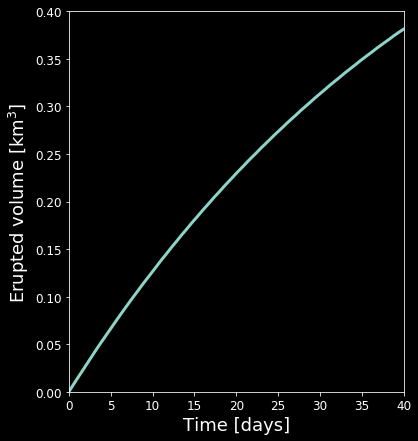

In [56]:
m = 1e+10
c0 = ps
Fs = ps * S
Fd = ps * R5
pd = ps - pspd
Pl = plps + ps
R5 = pd /ps
pstar = ps
tstar = ((m*V) / (k* S**2))**0.5
xstar = Fs*V/(k*S**2)
qstar = Fs *(V/(k*m))**0.5
Vstar = xstar * S
R1 = rho * g * V /(k*S)
R2 = (m * k / V)**0.5 *(3.14 * a**4 )/(8* mu * l* S) 
R3 = Pl / Fs * S
R4 = -1
x0 = x0/xstar
tc = 3.14 * a**4 *k/ (8* mu * l * V)
DeltaP,x,velocity,N_cycle,time,t_slip,dt_slip,dx_slip,slip_duration,q_out,vol_out,p_slip,dp_slip = isostatic_piston(x0,R1,R2,R3,R4,R5)
DeltaP = DeltaP * pstar
dx_slip = dx_slip * xstar
x = x * xstar
x = -x
vol_out = vol_out* Vstar
time = time * tstar
DeltaP_nocol = (Pl + DeltaP[0]) * np.exp(-tc *time) - Pl
V_nocol = V0/k *(DeltaP[0] + Pl) * (1 - np.exp(-tc * time))
DeltaP = DeltaP / 1e+6
DeltaP_nocol = DeltaP_nocol / 1e+6
vol_out = vol_out / 1e+9
V_nocol = V_nocol / 1e+9
time = time / (3600 *24)
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6,7))
ax.plot(time,vol_out,linewidth = 3)
ax.set_ylabel('Erupted volume [km$^3$]',fontsize= 18)
ax.tick_params(labelsize = 12)
ax.tick_params(labelsize = 12)
ax.set_xlabel('Time [days]',fontsize= 18)
ax.set_xlim([0,40])
ax.set_ylim([0,0.4])
plt.savefig(path_figs + 'volume_erupted_MAP.pdf')


In [59]:
N_cycle

49

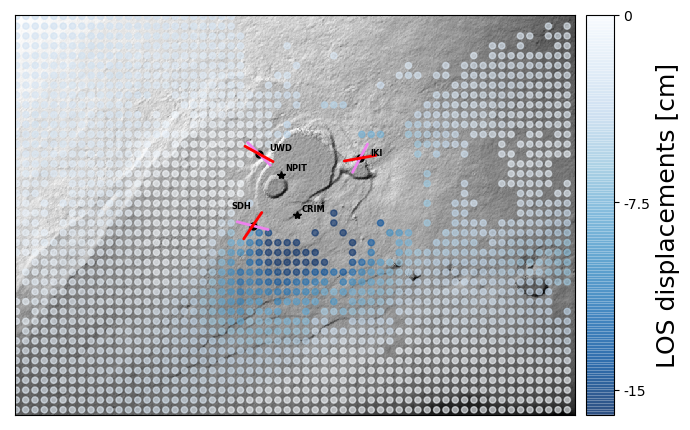

In [42]:
mpl.rcParams.update(mpl.rcParamsDefault)

llclon = np.min(lon_DEM)
llclat = np.min(lat_DEM)
urclon = np.max(lon_DEM)
urclat = np.max(lat_DEM)
#fig2 = plt.figure()
#ax2 = fig2.add_subplot(111)
#im_dummy = ax2.scatter(lon_downsamp_map,lat_downsamp_map,s = 20,c = los_downsamp*100,alpha = 1.0 ,cmap = 'Blues_r',vmin = -16, vmax =0)
blow, alow = signal.butter(2, 1e-4)
bhigh, ahigh = signal.butter(2, 1e-4,'high')
b, a = signal.butter(2, 0.03)
fig1 = plt.figure(1,figsize=(7,5))
map = Basemap(projection='tmerc', 
              lat_0=(llclat+urclat) * 0.5, lon_0=(llclon+urclon) * 0.5,
              llcrnrlon=llclon, 
              llcrnrlat=llclat, 
              urcrnrlon=urclon, 
              urcrnrlat=urclat)
lon_downsamp_map,lat_downsamp_map = map(lon_downsamp,lat_downsamp)
im1 = map.imshow(rgb,origin = 'upper',rasterized =True)
im2 = map.scatter(lon_downsamp_map,lat_downsamp_map,s = 20,c = los_downsamp*100,alpha = 0.6 ,cmap = 'Blues_r',vmin = -16, vmax =0)
cbar = map.colorbar(im2,shrink = 0.2,alpha = 1,ticks=[ 0,-7.5,-15])
cbar.ax.set_yticklabels(['0', '-7.5','-15']) 
cbar.set_label('LOS displacements [cm]',fontsize = 18)
cbar.solids.set_rasterized(True)


counter = 0
for name in list_station:
    x,y = map(stations[name]['lon_lat'][0],stations[name]['lon_lat'][1])

    east = stations[name]['east']
    north = stations[name]['north']
    time = stations[name]['time']
    '''
    Extract staff that is not nan
    '''
    npix =  750 # extension (in pixel) of the arrows
    indices = (np.isnan(north) == False) & (np.isnan(east) == False)
    time = time[indices] 
    east = east[indices] 
    north = north[indices] 
    east = (east - east[0]) 
    north = (north - north[0])
    time = time[::1]
    north = north[::1]
    east = east[::1]
    north_low = signal.filtfilt(blow, alow,north)
    east_low = signal.filtfilt(blow, alow,east)
    ff
    u1_low,w1_low,u2,w2,PCAmean = PCA_vectors(east_low,north_low) #Extract PCA vector and PCA mean
    u1_high,w1_high,u2,w2,PCAmean = PCA_vectors(east_high,north_high) #Extract PCA vector and PCA mean

    plt.figure(1)
    draw_vector([x,y],[x +u1_low*npix,y + w1_low*npix ],'violet')
    draw_vector([x,y],[x -u1_low*npix,y - w1_low*npix ],'violet')
    draw_vector([x,y],[x +u1_high*npix,y + w1_high*npix ],'red')
    draw_vector([x,y],[x -u1_high*npix,y - w1_high*npix ],'red')
    if not (name == 'UWE'):             #UWD and UWE are on the same site, plotting only UWE
        map.plot(x,y,'ko',markersize = 5)
    if (name == 'SDH'):
        plt.text(x-1000,y+800,name,color = 'black',fontsize = 6,fontweight = 'bold')
    else:
        plt.text(x+500,y+150,name,color = 'black',fontsize = 6,fontweight = 'bold')
    
    counter = counter + 1
lon_crim  = -155.274
lat_crim  = 19.395
lat_npit = 19.412
lon_npit = -155.281
x_crim,y_crim = map(lon_crim,lat_crim)
x_npit,y_npit = map(lon_npit,lat_npit)

plt.text(x_crim + 200,y_crim+200,'CRIM',color = 'black',fontweight = 'bold',fontsize = 6)
map.plot(x_crim,y_crim,'k*')
plt.text(x_npit + 200,y_npit+200,'NPIT',color = 'black',fontweight = 'bold',fontsize = 6)
map.plot(x_npit,y_npit,'k*')
plt.tight_layout()
plt.savefig(path_figs + 'interferogram_tilt.pdf',dpi = 800)

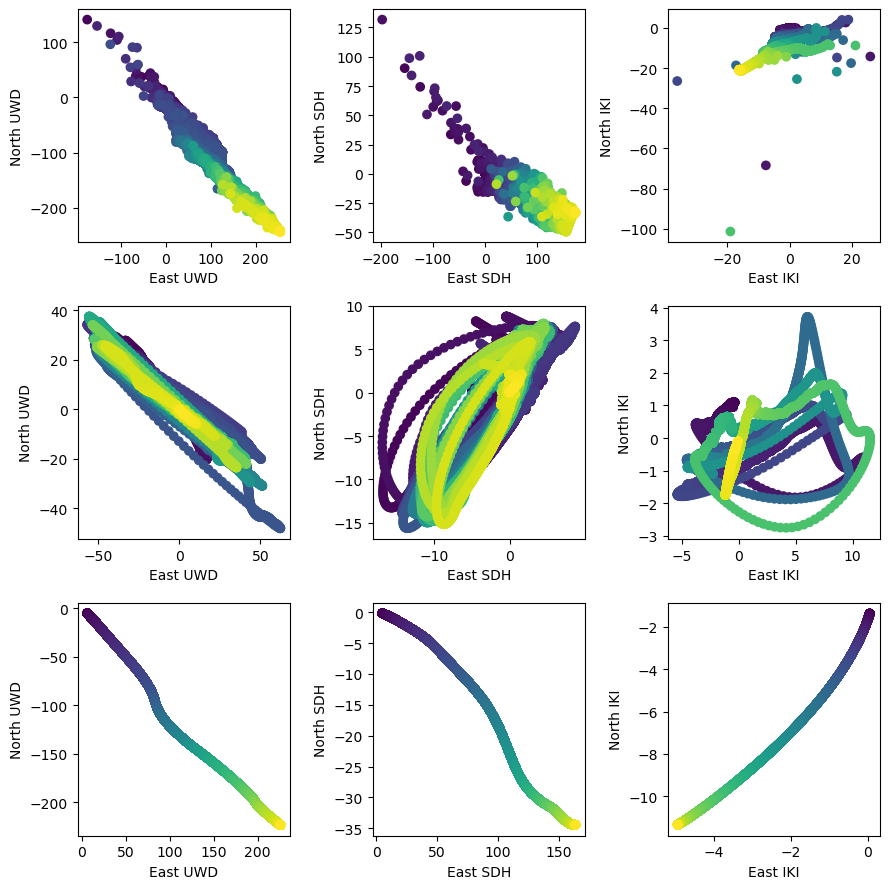

In [50]:
fig1,ax1 = plt.subplots(nrows = 3, ncols = 3,figsize=(9,9))
  
for counter,name in enumerate(list_station):
    east = stations[name]['east']
    north = stations[name]['north']
    time = stations[name]['time']
    '''
    Extract staff that is not nan
    '''    
    indices = (np.isnan(north) == False) & (np.isnan(east) == False)
    time = time[indices] 
    east = east[indices] 
    north = north[indices] 
    east = (east - east[0]) 
    north = (north - north[0])
    time = time[::1]
    north = north[::1]
    east = east[::1]
    north_low = signal.filtfilt(blow, alow,north)
    east_low = signal.filtfilt(blow, alow,east)
    north_high = signal.filtfilt(bhigh, ahigh,north)
    east_high = signal.filtfilt(bhigh, ahigh,east)
    north_high = signal.filtfilt(b, a,north_high)
    east_high = signal.filtfilt(b, a,east_high)
    u1_low,w1_low,u2,w2,PCAmean = PCA_vectors(east_low,north_low) #Extract PCA vector and PCA mean
    u1_high,w1_high,u2,w2,PCAmean = PCA_vectors(east_high,north_high) #Extract PCA vector and PCA mean
    ax1[0,counter].scatter(east,north,c = time)
    ax1[0,counter].set_xlabel('East ' + name)
    ax1[0,counter].set_ylabel('North ' + name)
    ax1[1,counter].scatter(east_high,north_high,c = time)
    ax1[1,counter].set_xlabel('East ' + name)
    ax1[1,counter].set_ylabel('North ' + name)
    ax1[2,counter].scatter(east_low,north_low,c = time)
    ax1[2,counter].set_xlabel('East ' + name)
    ax1[2,counter].set_ylabel('North ' + name)
plt.tight_layout()


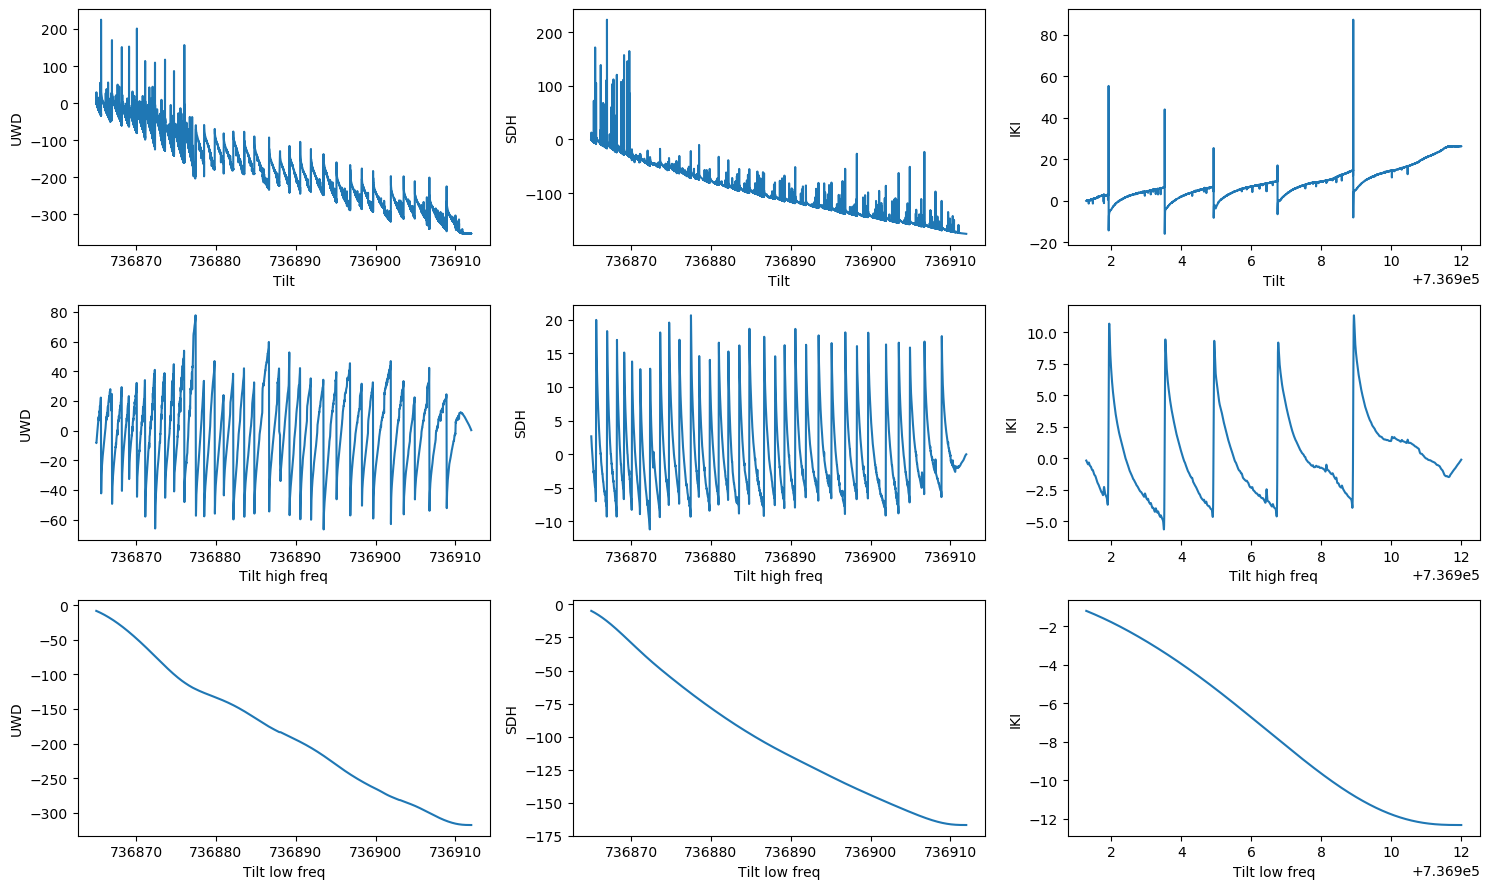

In [55]:
fig1,ax1 = plt.subplots(nrows = 3, ncols = 3,figsize=(15,9))
  
for counter,name in enumerate(list_station):
    x,y = map(stations[name]['lon_lat'][0],stations[name]['lon_lat'][1])

    east = stations[name]['east']
    north = stations[name]['north']
    time = stations[name]['time']
    '''
    Extract staff that is not nan
    '''
    npix =  750 # extension (in pixel) of the arrows
    indices = (np.isnan(north) == False) & (np.isnan(east) == False)
    time = time[indices] 
    east = east[indices] 
    north = north[indices] 
    east = (east - east[0]) 
    north = (north - north[0])
    time = time[::1]
    north = north[::1]
    east = east[::1]
    north_low = signal.filtfilt(blow, alow,north)
    east_low = signal.filtfilt(blow, alow,east)
    north_high = signal.filtfilt(bhigh, ahigh,north)
    east_high = signal.filtfilt(bhigh, ahigh,east)
    north_high = signal.filtfilt(b, a,north_high)
    east_high = signal.filtfilt(b, a,east_high)
    u1,w1,u2,w2,PCAmean = PCA_vectors(east,north) #Extract PCA vector and PCA mean
    u1_low,w1_low,u2,w2,PCAmean = PCA_vectors(east_low,north_low) #Extract PCA vector and PCA mean
    u1_high,w1_high,u2,w2,PCAmean = PCA_vectors(east_high,north_high) #Extract PCA vector and PCA mean
    proj_max = u1 * east + w1 * north
    proj_max_high = u1_high * east_high + w1_high * north_high
    proj_max_low = u1_low * east_low + w1_low * north_low
    ax1[0,counter].plot(time,proj_max)
    ax1[0,counter].set_xlabel('Tilt')
    ax1[0,counter].set_ylabel(name)
    ax1[1,counter].plot(time,proj_max_high)
    ax1[1,counter].set_xlabel('Tilt high freq')
    ax1[1,counter].set_ylabel(name)
    ax1[2,counter].plot(time,proj_max_low)
    ax1[2,counter].set_xlabel('Tilt low freq')
    ax1[2,counter].set_ylabel(name)
plt.tight_layout()

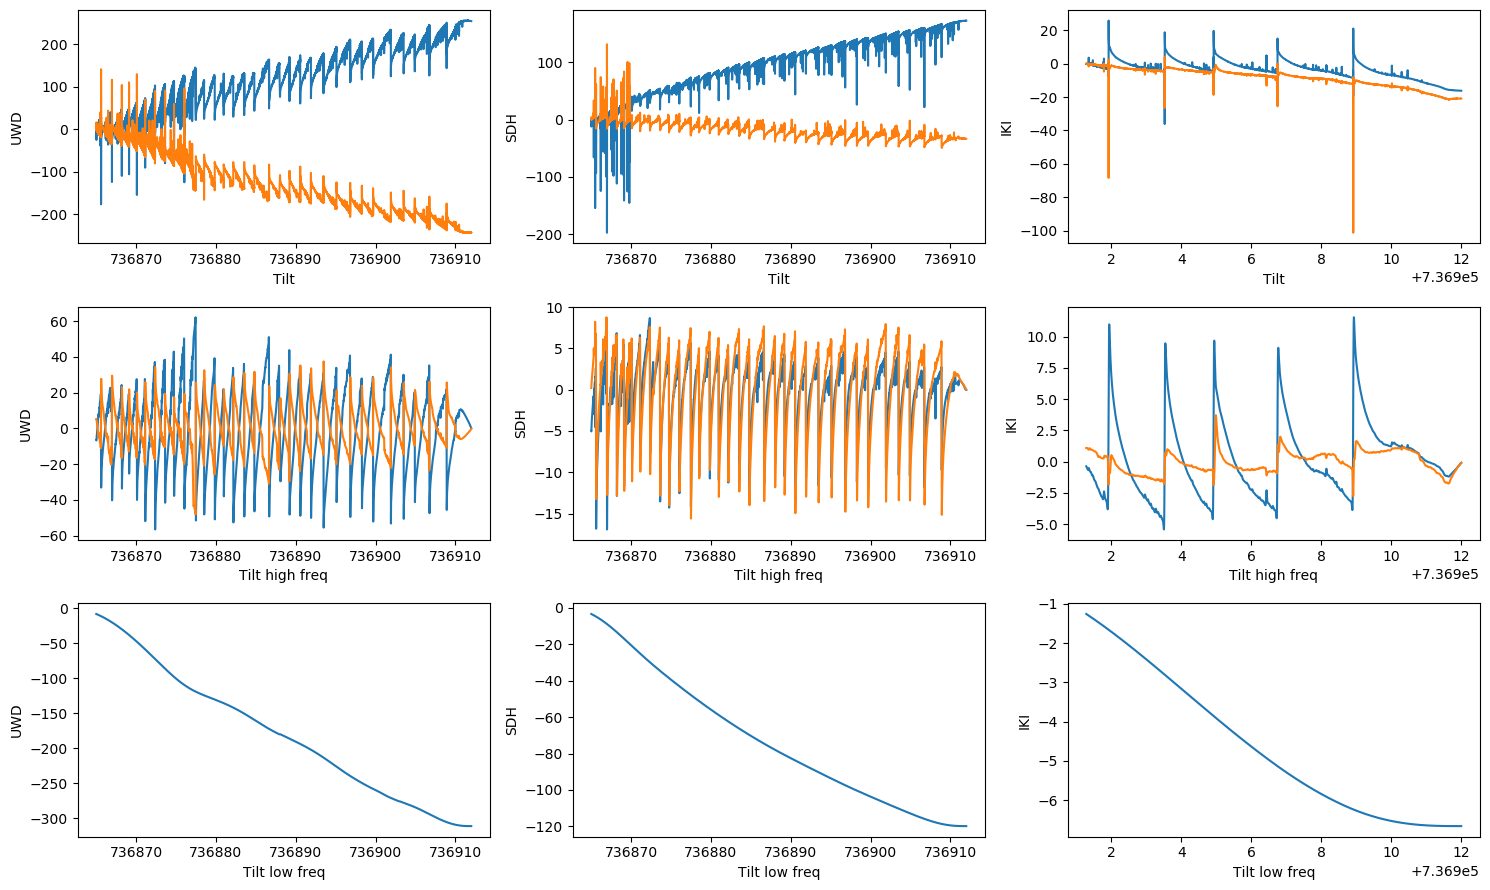

In [56]:
fig1,ax1 = plt.subplots(nrows = 3, ncols = 3,figsize=(15,9))
  
for counter,name in enumerate(list_station):
    x,y = map(stations[name]['lon_lat'][0],stations[name]['lon_lat'][1])

    east = stations[name]['east']
    north = stations[name]['north']
    time = stations[name]['time']
    '''
    Extract staff that is not nan
    '''
    npix =  750 # extension (in pixel) of the arrows
    indices = (np.isnan(north) == False) & (np.isnan(east) == False)
    time = time[indices] 
    east = east[indices] 
    north = north[indices] 
    east = (east - east[0]) 
    north = (north - north[0])
    time = time[::1]
    north = north[::1]
    east = east[::1]
    north_low = signal.filtfilt(blow, alow,north)
    east_low = signal.filtfilt(blow, alow,east)
    north_high = signal.filtfilt(bhigh, ahigh,north)
    east_high = signal.filtfilt(bhigh, ahigh,east)
    north_high = signal.filtfilt(b, a,north_high)
    east_high = signal.filtfilt(b, a,east_high)
    u1_low,w1_low,u2,w2,PCAmean = PCA_vectors(east_low,north_low) #Extract PCA vector and PCA mean
    u1_high,w1_high,u2,w2,PCAmean = PCA_vectors(east_high,north_high) #Extract PCA vector and PCA mean
    proj_max = u1 * east + w1 * north
    proj_max_high = u1_high * east_high + w1_high * north_high
    proj_max_low = u1 * east_low + w1_low * north_low
    ax1[0,counter].plot(time,east)
    ax1[0,counter].plot(time,north)
    ax1[0,counter].set_xlabel('Tilt')
    ax1[0,counter].set_ylabel(name)
    ax1[1,counter].plot(time,east_high)
    ax1[1,counter].plot(time,north_high)
    ax1[1,counter].set_xlabel('Tilt high freq')
    ax1[1,counter].set_ylabel(name)
    ax1[2,counter].plot(time,proj_max_low)
    ax1[2,counter].set_xlabel('Tilt low freq')
    ax1[2,counter].set_ylabel(name)
plt.tight_layout()